In [1]:
# Get helper functions file
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-03-20 20:29:09--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-03-20 20:29:09 (57.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

### Load the data

In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2024-03-20 20:29:15--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 74.125.137.207, 142.250.101.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   154MB/s    in 11s     

2024-03-20 20:29:26 (144 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [4]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/cannoli'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/red_velvet_cake'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/edamame'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/chocolate_mousse'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/beef_carpaccio'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/cheesecake'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/club_sandwich'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/nachos'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in 

In [5]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE= (224,224)
train_data_all_10_percent= tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                               label_mode='categorical',
                                                                               image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                               label_mode='categorical',
                                                               image_size=IMG_SIZE,
                                                               shuffle=False) #dont shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


### Feature extraction transfer learning with a pretrained EfficientNet model, then fine-tune

Steps to follow:
* Create a model checkpoint callback
* Create a data augmentation layer(may or may not work but need to check)
* Build a headless(no top layers) functional EfficientNetB0 backboned model
* compile model
* Feature extract for 5 full passes(5 epochs on train and validate on 15% of test data, to save epoch time)

In [6]:
#Create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                       save_weights_only=True, # save only the model weights
                                                       monitor='val_accuracy', # save the model weights which score the best validation accuracy
                                                       save_best_only=True) # only keep the best model weights on file (delete the rest)

In [7]:
# Create data augmentation layer to incorportae it into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
], name='data_augmentation')

In [8]:
#Setup base model and freeze its layers
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

#Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224,224,3), name='input_layer')
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name='global_average_pooling')(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names),activation='softmax', name='output_layer')(x)
model=tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 0s 0us/step


In [9]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling (Gl  (None, 1280)              0         
 obalAveragePooling2D)                                           
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                             

In [10]:
#Compile
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5,
                                           validation_data=test_data,
                                           validation_steps=int(0.15*len(test_data)),
                                           callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 162s 633ms/step - loss: 3.3709 - accuracy: 0.2755 - val_loss: 2.5300 - val_accuracy: 0.4378
Epoch 2/5
237/237 [==============================] - 110s 462ms/step - loss: 2.2080 - accuracy: 0.5002 - val_loss: 2.0686 - val_accuracy: 0.5021
Epoch 3/5
237/237 [==============================] - 95s 400ms/step - loss: 1.8282 - accuracy: 0.5615 - val_loss: 1.8804 - val_accuracy: 0.5254
Epoch 4/5
237/237 [==============================] - 85s 356ms/step - loss: 1.5991 - accuracy: 0.6094 - val_loss: 1.7882 - val_accuracy: 0.5352
Epoch 5/5
237/237 [==============================] - 79s 331ms/step - loss: 1.4499 - accuracy: 0.6413 - val_loss: 1.7583 - val_accuracy: 0.5410


In [11]:
fine_tuning_results = model.evaluate(test_data)
fine_tuning_results

790/790 [==============================] - 60s 76ms/step - loss: 1.5756 - accuracy: 0.5862


[1.5755796432495117, 0.5861782431602478]

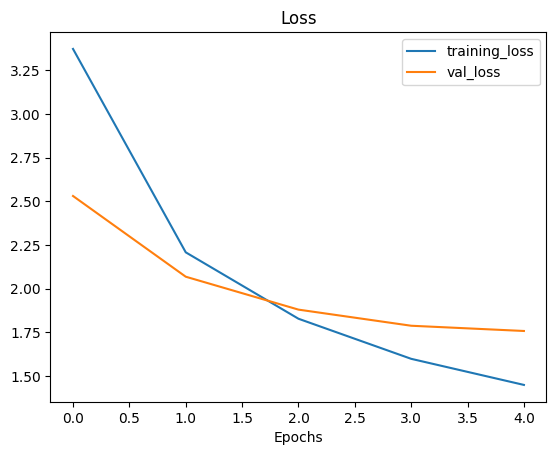

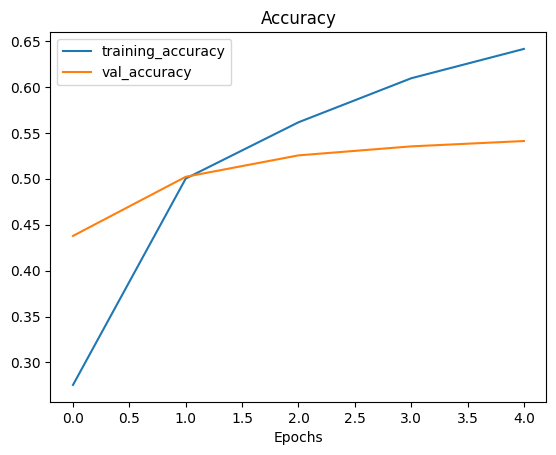

In [12]:
plot_loss_curves(history_all_classes_10_percent)

### Fine-tuning the model as the current one might be overfitting. (learning rate should be small in fine tuning)

In [13]:
# Unfreeze all layers in the base model
base_model.trainable=True

#Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable=False

In [14]:
#Recompile model with lower learning rate
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [15]:
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_average_pooling True
output_layer True


In [16]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [17]:
#Lets fine tune for 5 more epochs with these base model layers
fine_tune_epochs = 10

history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data = test_data,
                                                     validation_steps = int(0.15*len(test_data)),
                                                     initial_epoch = history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 81s 301ms/step - loss: 1.2076 - accuracy: 0.6826 - val_loss: 1.7016 - val_accuracy: 0.5495
Epoch 6/10
237/237 [==============================] - 69s 292ms/step - loss: 1.0930 - accuracy: 0.7060 - val_loss: 1.6760 - val_accuracy: 0.5593
Epoch 7/10
237/237 [==============================] - 65s 273ms/step - loss: 1.0163 - accuracy: 0.7277 - val_loss: 1.6774 - val_accuracy: 0.5601
Epoch 8/10
237/237 [==============================] - 65s 268ms/step - loss: 0.9476 - accuracy: 0.7460 - val_loss: 1.6950 - val_accuracy: 0.5591
Epoch 9/10
237/237 [==============================] - 60s 249ms/step - loss: 0.8905 - accuracy: 0.7638 - val_loss: 1.6842 - val_accuracy: 0.5612
Epoch 10/10
237/237 [==============================] - 56s 236ms/step - loss: 0.8328 - accuracy: 0.7762 - val_loss: 1.6902 - val_accuracy: 0.5567


In [18]:
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 [==============================] - 59s 75ms/step - loss: 1.4933 - accuracy: 0.6040


[1.493317723274231, 0.603960394859314]

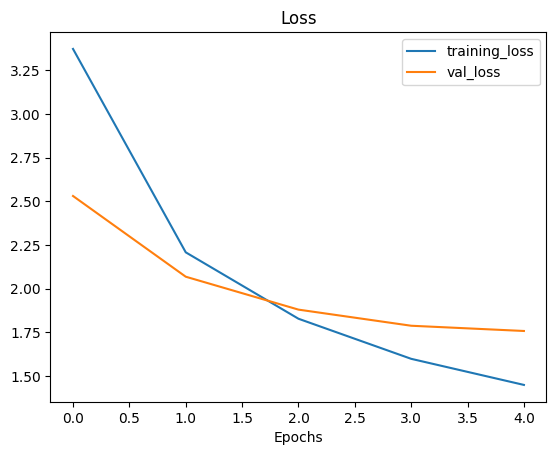

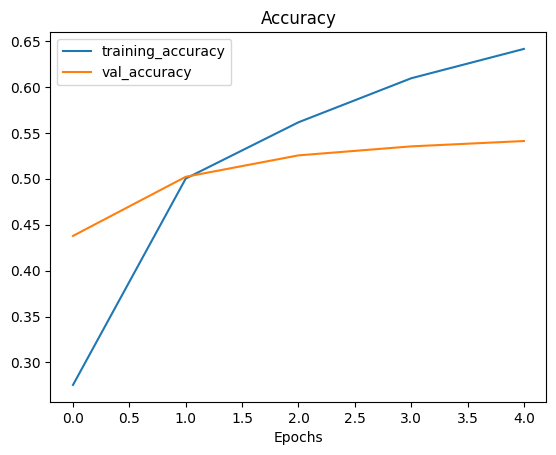

In [19]:
plot_loss_curves(history_all_classes_10_percent)

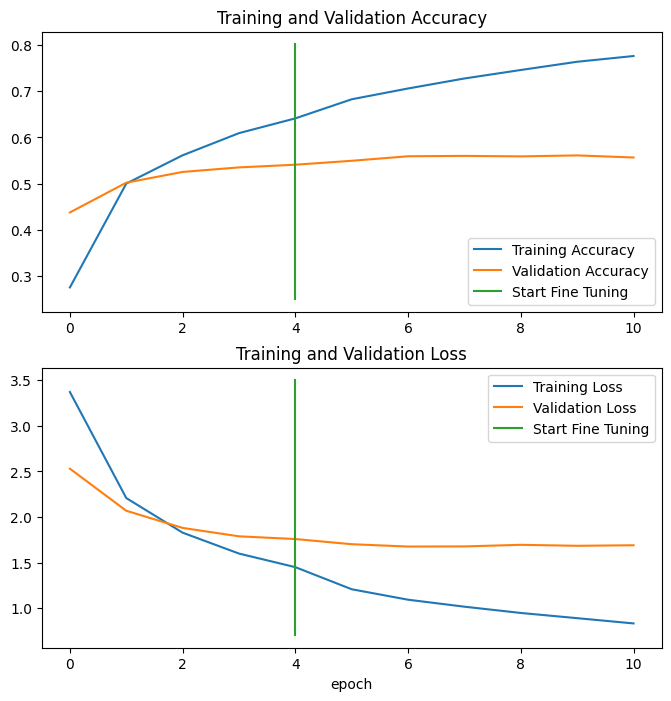

In [20]:
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

### Save the model

In [22]:
model.save("drive/MyDrive/101_food_classes_10_percent_saved_big_dog_model")

In [23]:
#Load and evaluate the saved model
loaded_model = tf.keras.models.load_model("drive/MyDrive/101_food_classes_10_percent_saved_big_dog_model")

In [24]:
#Evaluate loaded model and compare performance to pre-saved model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 66s 81ms/step - loss: 1.4933 - accuracy: 0.6040


[1.493317723274231, 0.603960394859314]

In [25]:
all_classes_10_percent_fine_tune_results

[1.493317723274231, 0.603960394859314]

### Evaluating the performance of the big dog model across all different classes

In [26]:
import tensorflow as tf
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2024-03-20 21:31:05--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.207, 142.251.2.207, 2607:f8b0:4023:c0d::cf, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M  81.5MB/s    in 0.5s    

2024-03-20 21:31:06 (81.5 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [27]:
saved_model_path = "06_101_food_class_10_percent_saved_big_dog_model.zip"
unzip_data(saved_model_path)

In [29]:
# Loading saved model
model = tf.keras.models.load_model("/content/06_101_food_class_10_percent_saved_big_dog_model")

In [30]:
 #Evaluate loaded model
 results_downloaded_model = model.evaluate(test_data)
 results_downloaded_model

790/790 [==============================] - 63s 77ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027204275131226, 0.6077623963356018]

### Make predictions with our model

In [31]:
preds_probs = model.predict(test_data, verbose=1)

790/790 [==============================] - 65s 80ms/step
